

ODESolve(f = derivatives(t,y), y0 = ICs, tspan = [0 tfinal], h)

EulerStep(f = derivatives, y = value, t = time, h = step)
      return value of y at t+h


In [2]:
import numpy as np
import matplotlib.pyplot as plt

Simple pendulum example, SAA

$$
\ddot{\theta} \approx - \frac{g}{l} \theta
$$

$$
\vec{y} = [\theta, \dot{\theta}]
$$

In [1]:
g = 9.8
l = 1

def pendulumDerivs(t,y):
  if(len(y)!=2):
    print("Error, n!=2 in pendulum equations")
  theta = y[0]
  thetadot = y[1]
  return np.array([thetadot, -g/l*theta])


In [3]:
def ODEStep(f,y,t,h,method):
  if(method=='RK4'):
    return RK4Step(f,y,t,h)
  elif(method=='RK2'):
    return RK2Step(f,y,t,h)
  elif(method=='EULER'):
    return EulerStep(f,y,t,h)
  else:
    exit()

def ODESolve(f,y0,tspan,h,method='RK4',abstol=1.0e-9,
             reltol=1.0e-9,adaptive=True,hmin=1.0e-50):
  t = tspan[0]
  tfinal = tspan[-1]
  y = y0
  ylist = np.ndarray((len(tspan),len(y0)))
  ylist[0] = np.array(y)
  nextI = 1
  S = 0.95
  while(t<=tfinal):
    ynew = ODEStep(f,y,t,h,method)
    if(adaptive):
      ybetter = ODEStep(f,y,t,h/2,method)
      ybetter = ODEStep(f,ybetter,t+h/2,h/2,method)
      Delta1 = (np.abs(ybetter-ynew))
      Delta0 = reltol*h*(np.abs(ynew))+h*abstol
      Ratio = np.max((Delta1/Delta0))
      stepSuccessful= False
      if(Ratio>1):
        ##retry the step, with smaller h
        h *= S*(1/Ratio)**0.2
        if(h<hmin):
          h = hmin
          print("WARNING STEP SIZE REQUESTED BELOW HMIN IN ODESOLVE")
          stepSuccessful = True
      else:
        stepSuccessful = True
      if(stepSuccessful):
        ##accept the step, consider increasing h
        tnew = t + h
        while(tnew>=tspan[nextI]):
          ylist[nextI] = y + (tspan[nextI]-t)/h*(ynew-y)
          nextI += 1
          if(nextI==len(tspan)):
            break      
        t = tnew
        y = ynew
        tiny = abstol**2
        h *= S*(1/(Ratio+tiny))**0.25
    else: #not adaptive, make this cleaner later too much redundancy
      tnew = t + h
      while(tnew>=tspan[nextI]):
        ylist[nextI] = y + (tspan[nextI]-t)/h*(ynew-y)
        nextI += 1
        if(nextI==len(tspan)):
          break      
      t = tnew
      y = ynew


  return ylist
    

In [4]:
def EulerStep(f,y,t,h):
  change = f(t,y)*h
  return(y+change)

$$
y(t+h) = y(t) + a k_1 + b k_2
$$

$$
k_1  = h f(t,y)
$$

$$
k_2 = h f(t+\alpha h, y + \beta k_1)
$$

In [5]:
# a + b = 1
# alpha = beta = (1/(2b))

a = -100
b = 1 - a
alpha = 1/(2*b)
beta = 1/(2*b)
def RK2Step(f,y,t,h):
  k1 = f(t,y)*h
  k2 = f(t+alpha*h,y+beta*k1)*h
  return(y+a*k1+b*k2)

In [6]:
def RK4Step(f,y,t,h):
  k1 = f(t,y)*h
  k2 = f(t+0.5*h,y+0.5*k1)*h
  k3 = f(t+0.5*h,y+0.5*k2)*h
  k4 = f(t+h,y+k3)*h
  return(y+(k1+2*k2+2*k3+k4)/6)

In [7]:
%%time
theta0 = 0.1
y0 = np.array([theta0 , 0])
tspan = np.linspace(0,1,10)
solution = ODESolve(pendulumDerivs,y0,tspan,0.001,reltol=1.0e-6,abstol=1.0e-6,method='RK4',adaptive=True)

CPU times: user 6.16 ms, sys: 0 ns, total: 6.16 ms
Wall time: 6.74 ms


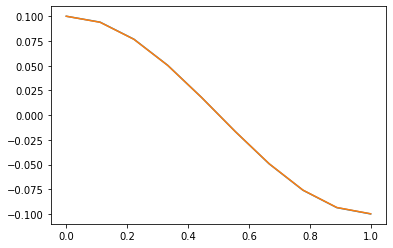

In [ ]:
plt.plot(tspan,theta0*np.cos(np.sqrt(g/l)*tspan))
plt.plot(tspan,solution[:,0])
plt.show()

In [ ]:
def aveAbsError(tspan,solution):
  return np.sum(np.abs(theta0*np.cos(np.sqrt(g/l)*tspan)-solution[:,0]))/len(tspan)

In [ ]:
print(aveAbsError(tspan,solution))

8.117829200070537e-05


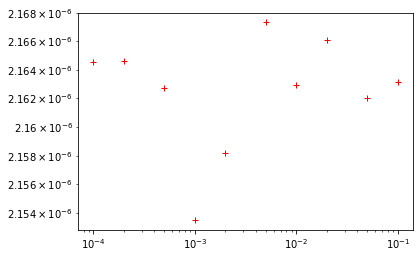

In [ ]:
hgrid = [0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001]
error = []
for h in hgrid:
  theta0 = 0.1
  y0 = np.array([theta0 , 0])
  tspan = np.linspace(0,20,1000)
  solution = ODESolve(pendulumDerivs,y0,tspan,h)
  error.append(aveAbsError(tspan,solution))

plt.loglog(hgrid,error,'r+')
plt.show()

In [ ]:
theta0 = 0.1
y0 = np.array([theta0 , 0])
tspan = np.linspace(0,1,10)

h = 0.1
solutionAdapt = []
solutionReg = []
timestep = []

i = 0
while i < 5:
  solutionAdapt.append(ODESolve(pendulumDerivs,y0,tspan,h,reltol=1.0e-6,abstol=1.0e-6,method='RK4',adaptive=True))
  solutionReg.append(ODESolve(pendulumDerivs,y0,tspan,h,reltol=1.0e-6,abstol=1.0e-6,method='RK4',adaptive=False))
  timestep.append(h)
  h = h*.1 #decrease timestep by 0.1 every iteration
  i = i+1
solutionAdapt = np.array(solutionAdapt)
solutionReg = np.array(solutionReg)

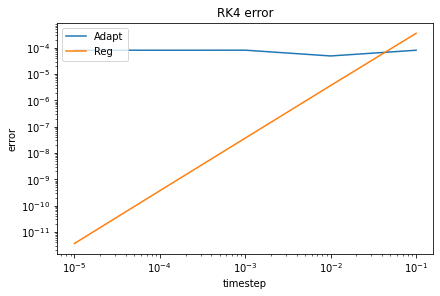

In [ ]:
errorAdapt = []
errorReg = []
for i in solutionAdapt:
  errorAdapt.append(aveAbsError(tspan,i))
for i in solutionReg:
  errorReg.append(aveAbsError(tspan,i))



fig, ax = plt.subplots(constrained_layout = True) 
ax.loglog(timestep, errorAdapt, label = 'Adapt') 
ax.loglog(timestep, errorReg,label = 'Reg') 
ax.set_xlabel('timestep') 
ax.set_ylabel('error') 
ax.set_title('RK4 error') 
plt.legend(loc="upper left")
plt.show()